# Exercise 7
## Empirical, functional and generalisation risk
### G. Bontempi


## Question
Consider an input/output regression task where $n=1$, 
$E[{\mathbf y}|x]=\sin( \pi/2 x)$,  $p(y|x) = {\mathcal N} (\sin( \pi/2 x),\sigma^2)$,
$\sigma=0.1$ and ${\mathbf x} \sim {\mathcal U}(-2,2)$. Let $N$ be the size of the training set
and consider a quadratic loss function.

Let the class of hypothesis be $h_M(x)=\alpha_0 +\sum_{m=1}^M \alpha_m x^m$ with
$\alpha_j \in [-2,2], \quad j=0,\dots,M$.

For $N=20$ generate $S=50$ replicates of the training set.
For each replicate, estimate the value of the parameters that minimise the empirical risk, 
compute the empirical risk and the functional risk.

The student should

* Plot the evolution of the distribution of the empirical risk for $M=0,1,2$.
* Plot the evolution of the distribution of the functional risk for $M=0,1,2$.
* Discuss the results.

Hints: to minimise the empirical risk, perform a grid search in the space of 
parameter values, i.e.  by sweeping all the possible values of the parameters in the set
$[-1,-0.9,-0.8,\dots,0.8,0.9,1]$.  To compute the functional risk generate a set of $N_{ts}=10000$ i.i.d. input/output testing samples.

## Regression function

Let us first define a function implementing the
conditional expectation function, i.e. the regression function



In [1]:

def regr_f(x):
    return np.sin(np.pi/2 * x)



## Parametric identification function

This function implements the parametric identification by performing
a grid search in the space of parameters.
Note that for a degree equal to $m$, there are $m+1$ parameters.
If each parameter takes value in a set of values of size $V$, the number
of configurations to be assessed by grid search amounts to $V^{m+1}$. Grid search is definitely
a poor way of carrying out a parametric identification. Here it is used only
to illustrate the notions of empirical risk.

In [25]:
def parident(X, Y, M=0):
    import numpy as np
    from itertools import product
    
    # set of values that can be taken by the parameter
    A = np.arange(-1, 1.1, 0.1)
    
    N = len(X)
    Xtr = np.ones(N)
    
    if M > 0:
        for m in np.arange(M):
            Xtr = np.column_stack((Xtr, X**(m+1)))
    
    # set of all possible combinations of values
    l = [A] * (M+1)
    cA = np.array(list(product(*l)))
    
    bestE = float('inf')
    
    # Grid search
    for i in range(len(cA)):
        #print(Xtr.shape)
        Yhat = np.dot(Xtr.reshape(-1,M+1), cA[i])
        ehat = np.mean((Yhat - Y)**2)
        if ehat < bestE:
            bestA = cA[i]  # best set of parameters
            bestE = ehat   # empirical risk associated to the best set of parameters
    
    return {'alpha': bestA, 'Remp': bestE}


## Monte Carlo simulation

Here we generate a number $S$ of training sets of size $N$.
For each of them we perform the parametric identification, we select
the set of parameters $\alpha_N$ and we compute the functional risk 
by means of a test set of size $N_{ts}$

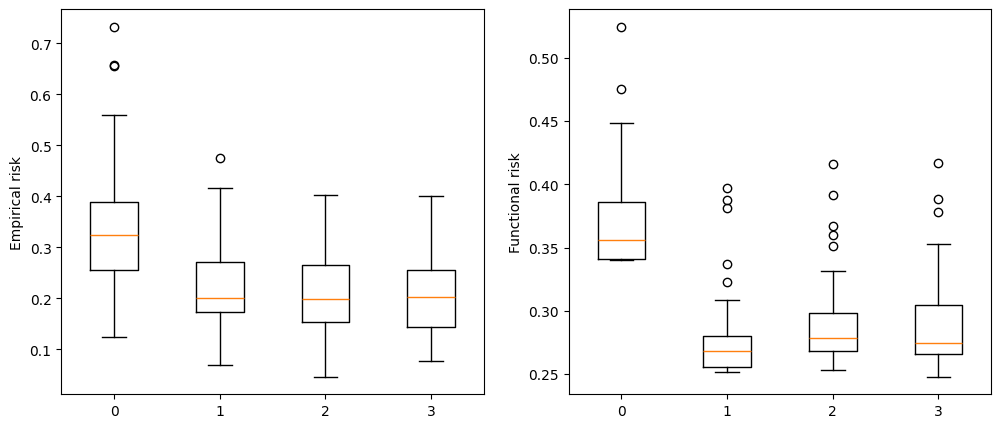

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform
import pdb; 
sdw = 0.5 ## noise stdev
S = 50 ## MC trails
N = 15
M = 3 ## max degree
aEmp = np.empty((S, M+1))
aFunct = np.empty((S, M+1))
Nts = 10000

# test set generation
Xts = uniform.rvs(size=Nts)
Yts = regr_f(Xts) + np.random.normal(0, sdw, Nts)

for m in np.arange(M+1):
    for s in range(S):
        # training set generation
        Xtr = uniform.rvs( size=N)
        Ytr = regr_f(Xtr) + np.random.normal(0, sdw, N)
        
        ParIdentification = parident(Xtr, Ytr, m)
        aEmp[s, m] = ParIdentification['Remp']
        
        XXts = np.ones((Nts, 1))
        if m > 0:
            for j in np.arange(m):
                XXts = np.column_stack((XXts, Xts**(j+1)))
        
        aFunct[s, m] = np.mean((Yts - XXts @ ParIdentification['alpha'].T)**2)
       

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot empirical risk
ax1.boxplot(aEmp)
ax1.set_xticklabels(np.arange(M+1))
ax1.set_ylabel('Empirical risk')

# Plot functional risk
ax2.boxplot(aFunct)
ax2.set_xticklabels(np.arange(M+1))
ax2.set_ylabel('Functional risk')

plt.show()
